<a href="https://colab.research.google.com/github/erco99/PADI-progetto/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione temperatura media della superficie di un Paese in un determinato periodo

**Corso di laurea triennale di Ingegneria e Scienze Informatiche, Università di Bologna, sede di Cesena**


*Programmazione di Applicazioni Data Intensive*


*Progetto d'esame di Francesco Ercolani*

# 1a. Descrizione del problema e comprensione dei dati

L'obiettivo di questo progetto è di realizzare un modello che, dato un Paese ed un periodo di tempo, sia in grado di predire la temperatura media della superficie in gradi Celsius.


Per fare ciò, si utilizzano i dati raccolti dal 1750 ad oggi.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

Carichiamo i due database da cui andremo ad estrarre i  dati:
il primo, "GlobalLandTemperaturesByCountry.csv", mi fornisce le informazioni necessarie riguardo alle temperature, mentre il secondo "owid-co2-data.csv", mi dà le informazioni riguardanti la produzione di gas.


In [33]:
file = "GlobalLandTemperaturesByCountry.csv"
file1 = "co2_data.cvs"
if not os.path.exists(file):
  from urllib.request import urlretrieve
  urlretrieve("https://raw.githubusercontent.com/erco99/PADI-progetto/main/GlobalLandTemperaturesByCountry.csv", file)
  urlretrieve("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv", file1)


In [43]:
temperatures = pd.read_csv(file, index_col="date", parse_dates=["date"])

In [44]:
gas_consumptions = pd.read_csv(file1, index_col="year")

Mostriamo i dataset appena caricati:

In [45]:
temperatures.head(5)

,averageTemperature,averageTemperatureUncertainty,country
date,,,
1743-11-01,4.384,2.294,Åland
1743-12-01,NaN,NaN,Åland
1744-01-01,NaN,NaN,Åland
1744-02-01,NaN,NaN,Åland
1744-03-01,NaN,NaN,Åland


In [46]:
gas_consumptions.head(5)

,iso_code,country,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1949,AFG,Afghanistan,0.015,NaN,NaN,NaN,NaN,0.002,NaN,0.0,0.015,0.0,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1950,AFG,Afghanistan,0.084,NaN,475.0,0.070,NaN,0.011,NaN,0.0,0.099,0.0,0.009,NaN,NaN,0.021,NaN,NaN,NaN,0.063,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.036,NaN,NaN,0.063,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
1951,AFG,Afghanistan,0.092,NaN,8.7,0.007,NaN,0.012,NaN,0.0,0.191,0.0,0.010,NaN,NaN,0.026,NaN,NaN,NaN,0.066,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.061,NaN,NaN,0.129,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
1952,AFG,Afghanistan,0.092,NaN,0.0,0.000,NaN,0.012,NaN,0.0,0.282,0.0,0.009,NaN,NaN,0.032,NaN,NaN,NaN,0.060,NaN,NaN,0.004,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.093,NaN,NaN,0.189,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
1953,AFG,Afghanistan,0.106,NaN,16.0,0.015,NaN,0.013,NaN,0.0,0.388,0.0,0.010,NaN,NaN,0.038,NaN,NaN,NaN,0.068,NaN,NaN,0.005,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.131,NaN,NaN,0.257,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


Notiamo che il primo dataset registra i dati mese per mese, mentre il secondo anno per anno. È quindi necessario, per la creazione di un dataset unico, fare una media annuale dei valori registrati anno per anno per ogni Paese all'interno del dataset **temperatures**.

Inoltre, non andremo a considerare tutte le colonne del dataset gas_consumptions, ma soltanto quelle relative alla produzione di co2, metano e ossido di diazoto.

In [47]:
temperatures['year'] = temperatures.index.year
temperatures = temperatures.groupby(['country', 'year']).mean()
temperatures.reset_index(inplace=True)
temperatures.set_index('year', inplace=True)

In [48]:
temperatures.head()

,country,averageTemperature,averageTemperatureUncertainty
year,,,
1838,Afghanistan,18.379571,2.756000
1839,Afghanistan,NaN,NaN
1840,Afghanistan,13.413455,2.502000
1841,Afghanistan,13.997600,2.452100
1842,Afghanistan,15.154667,2.381222


Per creare il dataset finale sul quale si potrà procedere con l'analisi, uniamo i due dataframe **temperatures** e **gas_consumptions** su year e country, e lasciamo soltanto le colonne che ci interessano, ovvero quelle più importanti per il nostro scopo.

In [49]:
dataset = pd.merge(temperatures, gas_consumptions, on=['year', 'country'])
dataset = dataset[['country', 'averageTemperature', 'averageTemperatureUncertainty', 'co2', 'methane', 'nitrous_oxide', 'population']]

Abbiamo così ottenuto il dataset completo.

In [50]:
dataset.tail()

,country,averageTemperature,averageTemperatureUncertainty,co2,methane,nitrous_oxide,population
year,,,,,,,
2009,Zimbabwe,21.377250,0.436417,5.476,11.35,6.70,12526964.0
2010,Zimbabwe,21.986250,0.409667,7.864,11.87,7.11,12697728.0
2011,Zimbabwe,21.602417,0.393417,9.480,12.26,7.26,12894323.0
2012,Zimbabwe,21.521333,0.538500,7.659,12.17,6.92,13115149.0
2013,Zimbabwe,20.710750,0.778500,11.617,12.08,6.67,13350378.0


Come si può osservare sopra, le **features** disponibili sono:
1. **`year`**: anno in cui sono stati registrati i dati
2. **`country`**: paese a cui fanno riferimento i dati
3. **`averageTemperature`**: temperatura media
4. **`averageTemperatureUncertainty`**: incertezza media calcolata con un livello di confidenza del 95% della temperatura media
5. **`co2`**: produzione annuale di diossido di carbonio (CO2) misurata in milioni di tonnellate
6. **`methane`**: emissione annuale di metano misurata in milioni di tonnellate di CO2 equivalente
7. **`nitrous_oxide`**: emissione annuale di ossido di diazoto misurata in milioni di tonnellate di CO2 equivalente
8. **`population`**: popolazione totale del rispettivo paese nel rispettivo anno

Le features, a parte `year` e `country` che sono categoriche, sono continue.

# 1b. Analisi esplorativa dei dati

### Esplorazione generale

Analizziamo ora i dati per avere una visione più ottimale dell'obiettivo.

In [51]:
print("Country: " + str(dataset["country"].nunique()))
print("Years: " + str(dataset.index.nunique()))

Country: 188
Years: 264


Vediamo che il dataset contiene dati riguardanti 187 Paesi e il range temporale massimo entro il quale sono stati raccolti dati è di 264 anni.
Osserviamo quali sono i Paesi all'interno del dataset di cui si hanno più dati, ovvero che hanno il range temporale più alto.

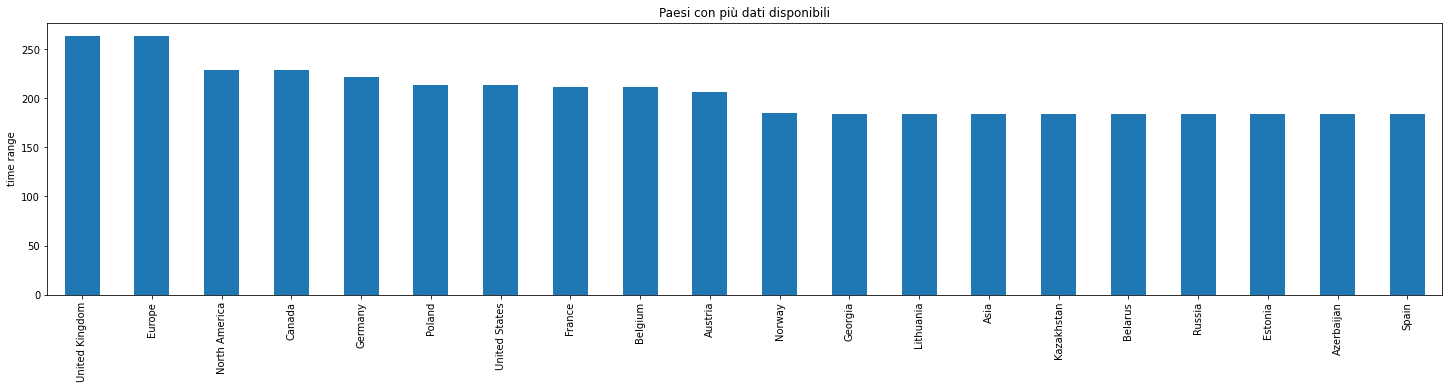

In [52]:
ax = dataset["country"].value_counts()[:20].plot.bar(figsize=(25,5))
ax.set_title("Paesi con più dati disponibili")
plt.ylabel('time range')
plt.show()

Come si può notare, il Paese con più dati registrati è il Regno Unito. È importante sottolinere inoltre che all'interno del dataset sono presenti anche i dati relativi ai continenti, e potranno essere trattati separatamente più avanti.

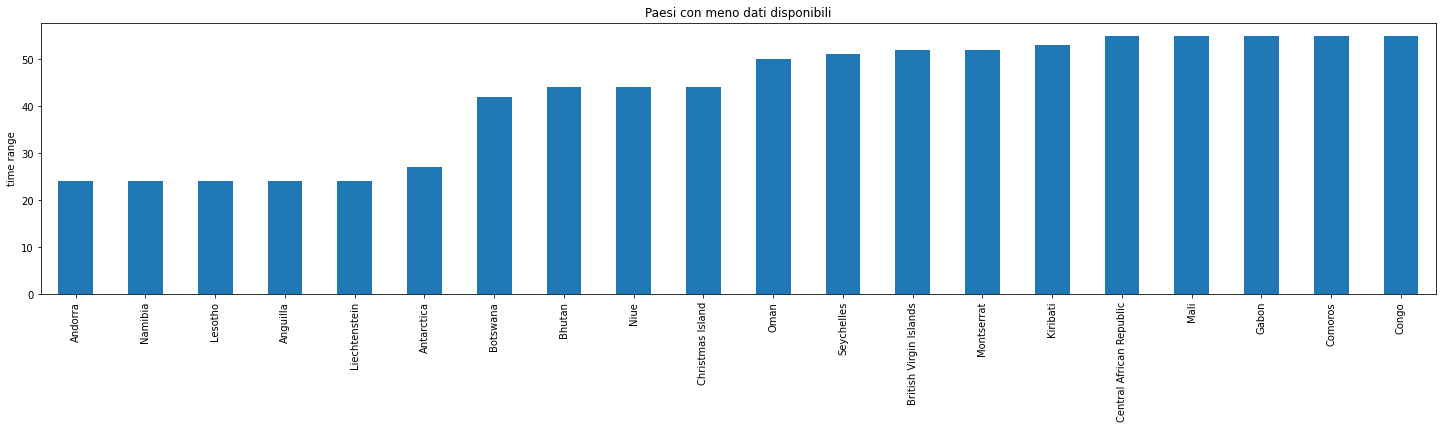

In [53]:
ax = dataset["country"].value_counts(ascending=True)[:20].plot.bar(figsize=(25,5))
ax.set_title("Paesi con meno dati disponibili")
plt.ylabel('time range')
plt.show()

Allo stesso modo, notiamo che Puerto Rico è il Paese con meno dati disponibili.

In [54]:
continents = ['Europe', 'Africa', 'Asia', 'North America', 'South America', 'Oceania']

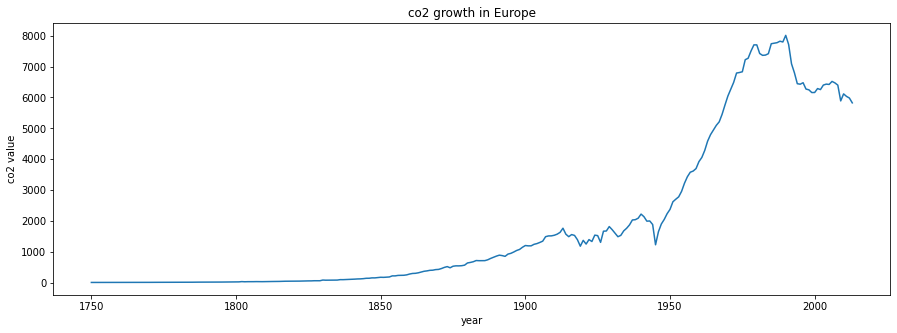

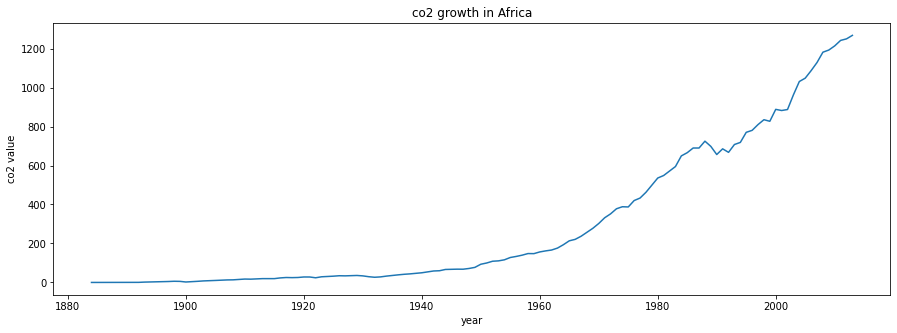

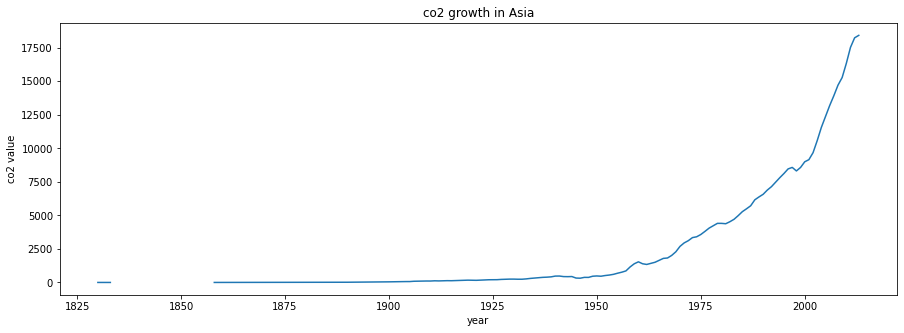

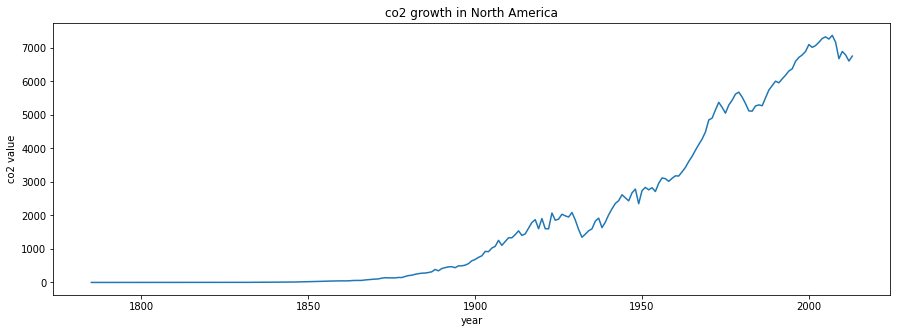

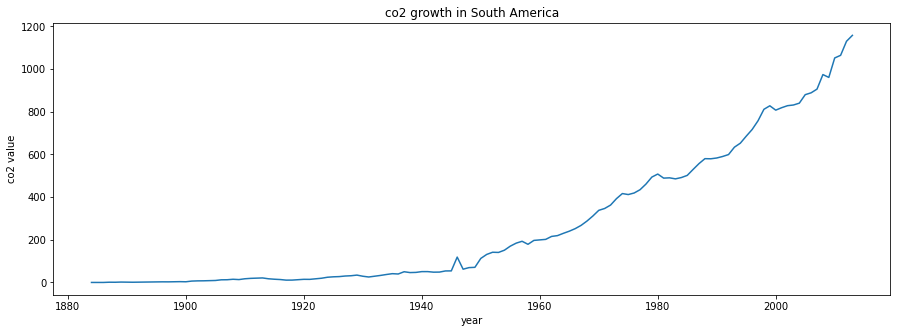

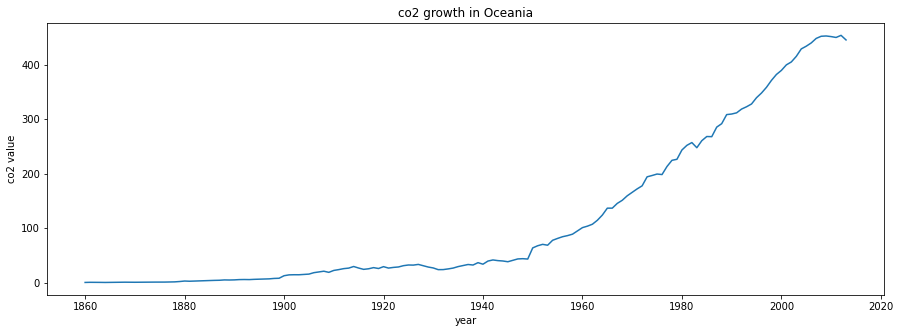

In [55]:
for continent in continents:
  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(dataset.query("country == @continent").index, dataset.query("country == @continent")[['co2']].values)
  ax.set(xlabel='year', ylabel='co2 value', title='co2 growth in ' + continent)
  plt.show()

Possiamo notare come la produzione di CO2 sia sensibilmente aumentata negli anni in tutti i continenti (escluso l'Antartide per mancanza di dati).

### Esplorazione relazioni fra feature

Mettiamo ora a confronto l'aumento di produzione di CO2 con l'aumento della temperatura media nei continenti:

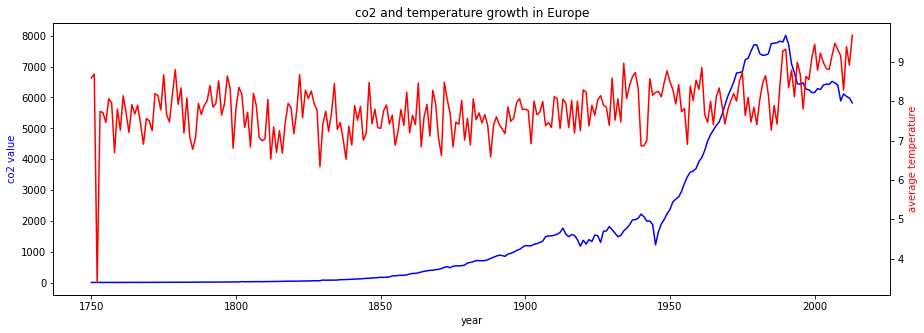

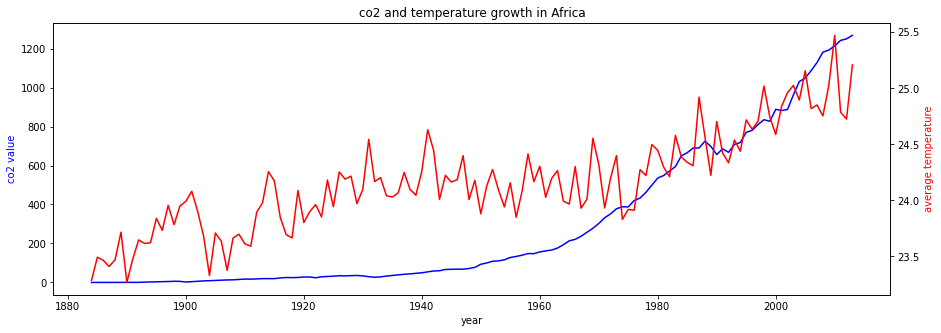

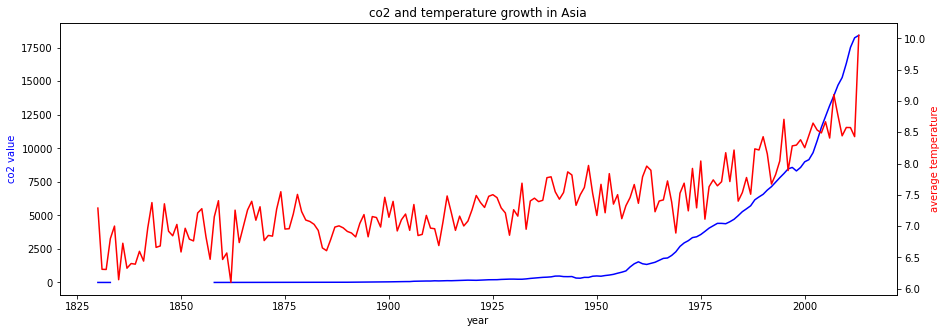

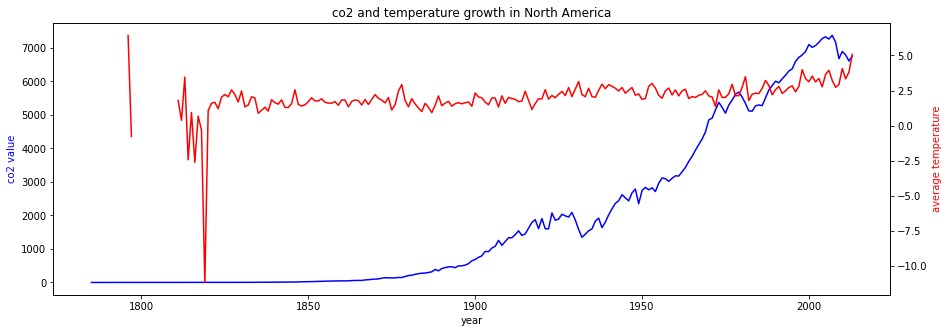

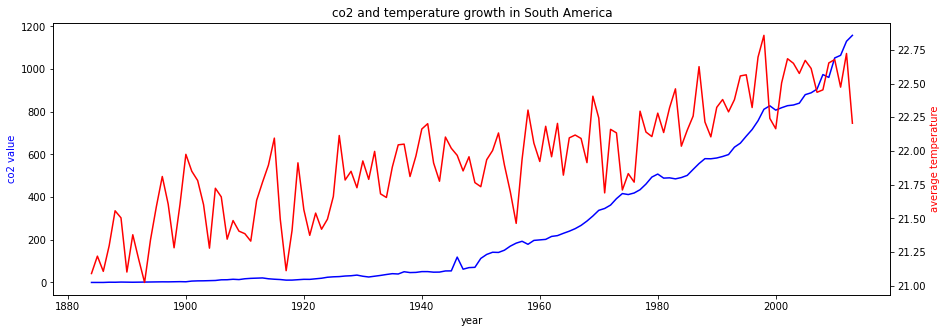

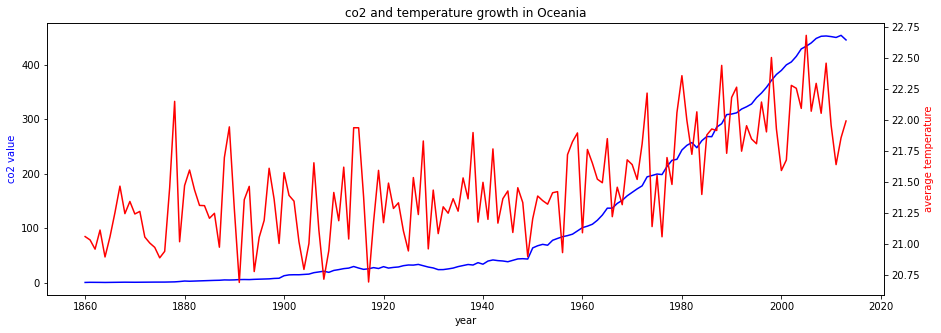

In [56]:
for continent in continents:
  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(dataset.query("country == @continent").index, dataset.query("country == @continent")[['co2']].values, color="blue")
  ax.set_xlabel("year")
  ax.set_ylabel("co2 value", color="blue")
  ax.set_title('co2 and temperature growth in ' + continent)
  ax2 = ax.twinx()
  ax2.plot(dataset.query("country == @continent").index, dataset.query("country == @continent")[['averageTemperature']].values, color="red")
  ax2.set_ylabel("average temperature", color="red")
  plt.show()

A sinistra abbiamo i valori di produzione di CO2, mentre a destra quelli della temperatura media, ciascuno di essi legato alla curva del colore della propria label. È evidente, in modo più marcato in South America, Oceania, Asia ed Africa, che ad un aumento della produzione di CO2 è corrisposto l'aumento della temperatura media.

Non è possibile fare una correlazione simile a causa della mancanza di dati sui continenti riguardanti metano e ossido di diazoto (sono presenti soltanto dati sui singoli Paesi).

I dati su metano e ossido di diazoto tuttavia sono presenti, per i singoli Paesi, soltanto dal 1989 in su. Per fare una giusta analisi bisogna tenere conto dei limiti imposti tramite trattati internazionali sulla produzione di gas inquinanti. Osserviamo quindi la differenza di crescita di questi due gas tra Paesi sottoposti a limiti e non:

In [57]:
def plot_growth(country, gas,):
  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(dataset.query("country == @country").index, dataset.query("country == @country")[[gas]].values)
  ax.set_xlabel("year")
  ax.set_ylabel(gas + " value")
  ax.set_title(gas + " growth in " + country )
  return ax

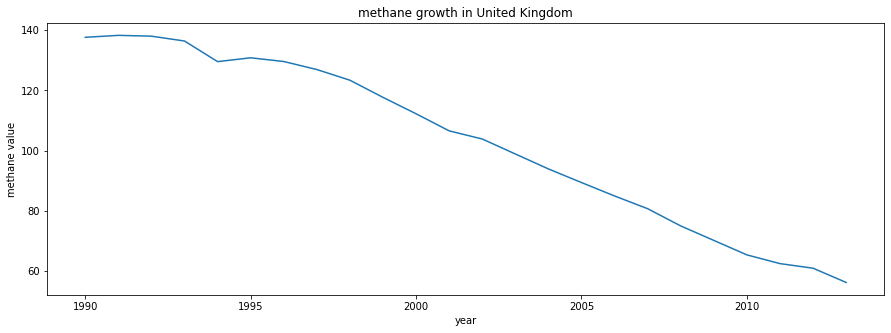

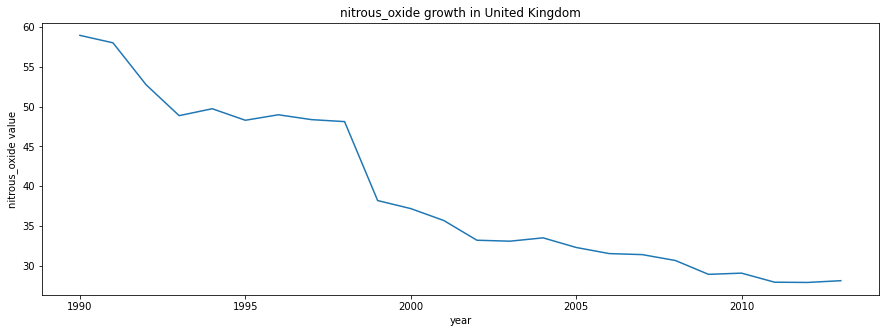

In [58]:
plot_growth('United Kingdom', 'methane')
plot_growth('United Kingdom', 'nitrous_oxide')
plt.show()

Nel Regno Unito negli ultimi 25 anni c'è stata una decrescita di produzione sia di metano che di ossido di diazoto.

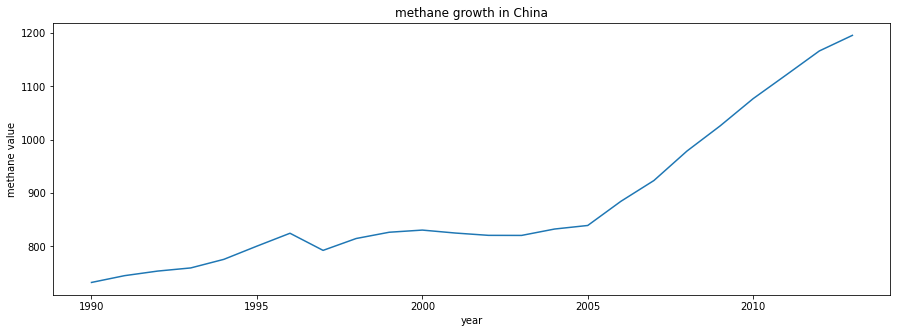

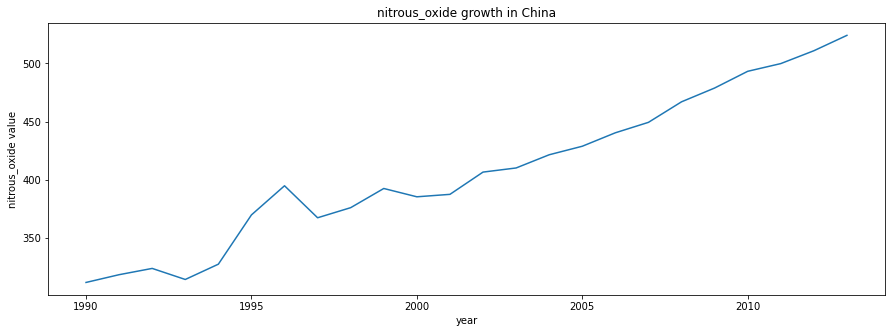

In [59]:
plot_growth('China', 'methane')
plot_growth('China', 'nitrous_oxide')
plt.show()

In Cina si è avuta invece una crescita, diretta conseguenza della mancanza o insufficienza di limiti.

In [60]:
def plot_mn_growth(country):
  query = dataset.query("country == @country");
  query1 =  dataset.query("country == @country and year > 1990");

  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(query1.index, query1[['averageTemperature']].values, color="red")
  ax.set_xlabel("year")
  ax.set_ylabel("temperature", color="red")
  ax.set_title('methane, nitrous oxide and temperature growth in ' + country)
  ax2 = ax.twinx()
  ax2.plot(query.index, query[['methane']].values, label="methane")
  ax2.plot(query.index, query[['nitrous_oxide']].values, label='nitrous oxide')
  ax2.set_ylabel("methane and nitrous oxide values")
  ax2.legend(loc=0)

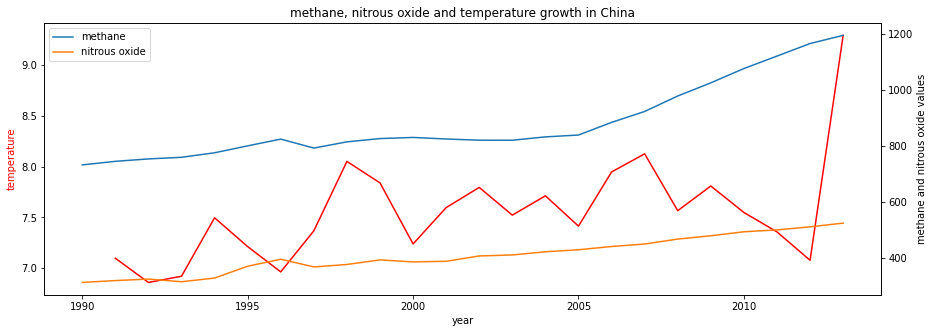

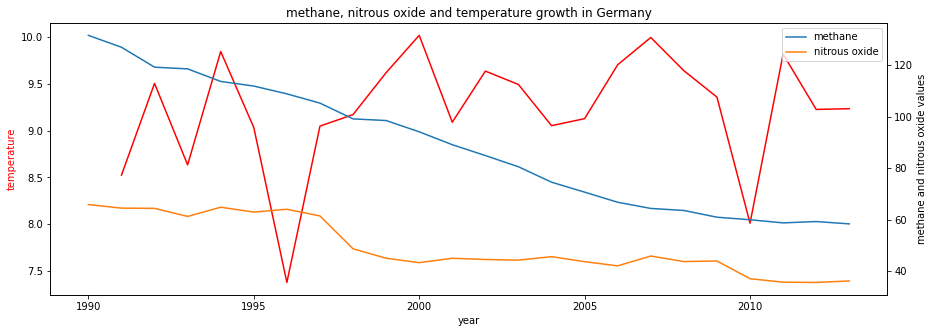

In [61]:
plot_mn_growth('China')
plot_mn_growth('Germany')
plt.show()

I grafici mostrano come in Cina apparentemente una crescita di produzione di metano corrisponda con la crescita della temperatura media degli ultimi anni. Il metano è un inquinante di breve durata e quindi è bene tenerlo in considerazione in relazione ad aumenti/diminuzioni della temperatura drastici. 
In Germania, al contrario, la temperatura è rimasta stabile negli ultimi 25 anni.

### Data cleaning

Vediamo quanti valori nulli sono presenti nel dataset:

In [62]:
dataset.isna().sum()

country                              0
averageTemperature                  93
averageTemperatureUncertainty       66
co2                                799
methane                          14892
nitrous_oxide                    14892
population                         257
dtype: int64

Il numero maggiore di valori nulli si ha nelle colonne indicanti la produzione di metano e di ossido di diazoto, infatti come già spiegato in precedenza i valori di queste due colonne sono stati registrati soltanto a partire dal 1989.
Per il nostro obiettivo però è importante che non ci siano anni in cui non sono presenti nè dati su metano e ossido di diazoto, nè su CO2 e temperatura media.
Procediamo quindi ad eliminare le righe corrispondenti:

In [63]:
dataset.dropna(subset=['averageTemperature', 'averageTemperatureUncertainty', 'co2'], inplace=True)

Procediamo anche ad eliminare le righe i cui la colonna population ha valore nullo.

In [64]:
dataset.dropna(subset=['population'], inplace=True)

In [65]:
dataset.isna().sum()

country                              0
averageTemperature                   0
averageTemperatureUncertainty        0
co2                                  0
methane                          13866
nitrous_oxide                    13866
population                           0
dtype: int64

In [66]:
dataset.nunique()

country                            185
averageTemperature               17670
averageTemperatureUncertainty    11040
co2                              11309
methane                           2528
nitrous_oxide                     1810
population                       17921
dtype: int64

Il dataset presenta un numero sufficiente di valori distinti.

Tuttavia, per la generazione dei modelli bisogna che non ci siano valori nulli.
Con l'eliminazione delle righe in cui metano e diossido non hanno valori, si eliminerebbero troppi dati sulla co2, quindi creiamo due dataset distinti:  

Il primo, senza i dati sul metano e il diossido

In [67]:
 dataset_co2 = dataset.copy().drop(columns=["methane", "nitrous_oxide"])

Il secondo, senza i dati sulla co2, e quindi comprendenti il range temporale dal 1989 in poi per ogni paese

In [68]:
dataset_mn = dataset.copy().dropna(subset=["methane", "nitrous_oxide"]) 
dataset_mn.drop(columns=["co2"], inplace=True)

#2. Feature preprocessing

### Correlazioni tra features

L'obiettivo è quello di ottenere un modello di regressione che sia in grado di stimare la temperatura media di un determinato Paese. In questa fase analizziamo eventuali dipendenze o correlazioni tra features.

In [69]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Iniziamo mostrando la correlazione tra features nel dataset_co2:

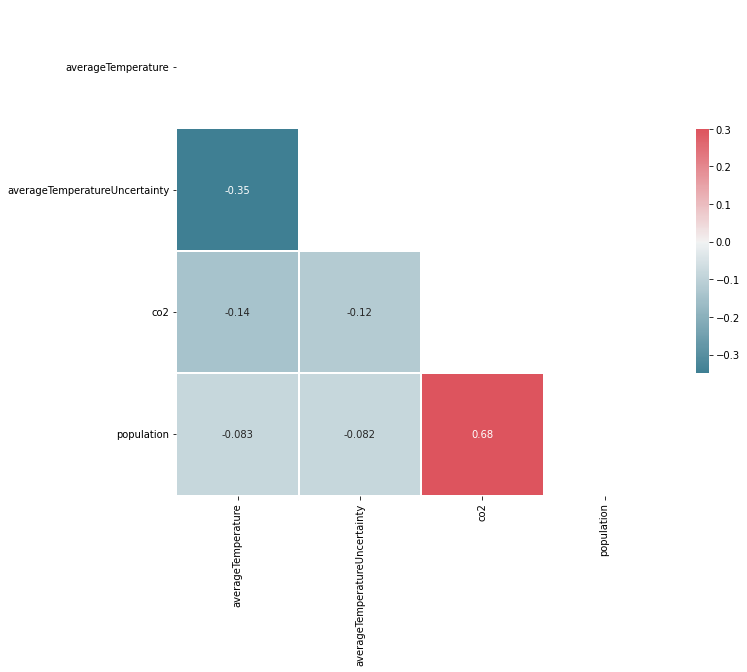

In [70]:
plot_correlation(dataset_co2.corr())

Come osserviamo, i dati sembrano non coincidere con ciò che è stato evidenziato nella fase precedente, questo perché ogni Paese ha una temperatura diversa e quindi, ad esempio, se in italia la produzione di CO2 nel 1980 è stata di 386 e la temperatura media era di 12 gradi, in un altro Paese con lo stesso livello di produzione di co2 può corrispondere una temperatura media totalmente diversa per motivi geografici.
Proviamo allora a mostare la correlazione tra features in un singolo Paese:

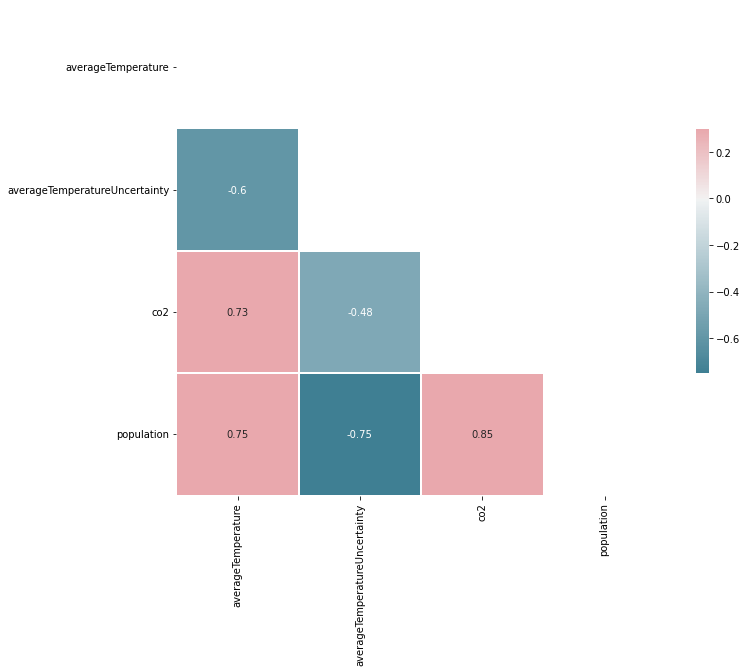

In [71]:
plot_correlation(dataset_co2.query("country == 'China'").corr())

**`averageTemperature e co2`**: temperatura media e produzione di CO2 sono correlate, ad una produzione maggiore di co2 corrisponde un aumento della temperatura.

**`averageTemperature e population`**: notiamo come anche il valore della popolazione di un Paese sia correlato alla temperatura media, questo probabilmente perché all'aumento della popolazione corrisponde un aumento dei consumi.

**`population e co2`**: si conferma la tesi accennata sopra. L'aumento della popolazione di un Paese genera anche un aumento della produzione dei consumi e di conseguenza anche di CO2.

Guardiamo ora la correlazione tra features in dataset_mn:

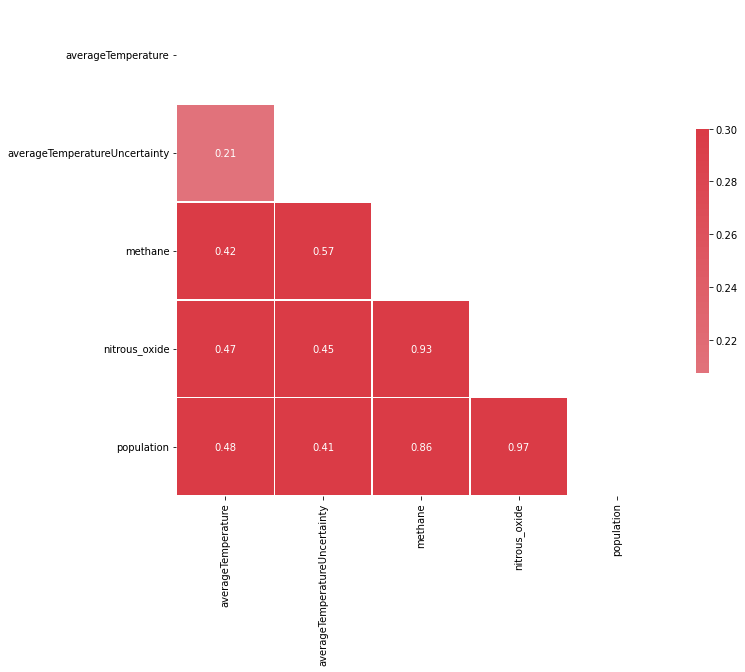

In [72]:
plot_correlation(dataset_mn.query("country == 'China'").corr())

Come già spiegato, `dataset_mn` contiene soltanto dati dal 1989 in su e quindi è facile che alcune relazioni non siano veritiere, prendiamo allora in esame soltanto le più rilevanti.

**`methane and nitrous_oxide`**: metano e diossido di diazoto sono entrambi collegati all'intensificazione della produzione di cibo, ed è per questo che aumentano a livelli simili.
**`population e methane/nitrous_oxide`**: anche metano e diossido di diazoto sono strettamente collegati ad un aumento della popolazione.

**`averageTemperature e methane/nitrous_oxide`**: la relazione tra la temperatura e il metano/diossido di diazoto è meno evidente rispetto a quella con la CO2, è tuttavia presente.

### Divisione dei dati

Procediamo ora con la definizione dei metodi per la divisione dei dati che ci servirà per la modellazione.

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
def dataset_split(dt):
  dtt = dt.copy()
  return train_test_split(
    dtt.drop(["averageTemperature"], axis=1),
    dtt["averageTemperature"],
    test_size=1/3, random_state=42
  )   

In [75]:
def country_drop(dt):
  dt.drop(columns='country', inplace=True)

Prendendo l'intero dataset per il training non è una buona idea viste le differenze geografiche tra Paesi, e quindi le differenze di temperatura tra essi. Considerato questo, prendiamo un insieme di Paesi con temperatura media simile così da avere un dataset più vasto rispetto ad uno con i soli dati di un singolo Paese. Si può addestrare il modello anche sui dati di un solo Paese, però il training non sarebbe ottimale.

Selezioniamo i Paesi con una temperatura media compresa tra i 25.2 e 25.9 gradi:

In [76]:
sel = dataset.groupby("country").mean().query("averageTemperature > 25.2 & averageTemperature < 25.9 ").filter(['country']).index
print(sel)

Index(['Bahamas', 'Bangladesh', 'Belize', 'Central African Republic', 'Cuba',
       'El Salvador', 'Equatorial Guinea', 'Fiji', 'Indonesia', 'Kuwait',
       'Liberia', 'Niue', 'Venezuela'],
      dtype='object', name='country')


In [77]:
co2_pred_test = dataset_co2.query("country in @sel")
mn_pred_test = dataset_mn.query("country in @sel")

In [78]:
dataset_co2_x_train, dataset_co2_x_val, dataset_co2_y_train, dataset_co2_y_val = dataset_split(dataset_co2.query("country in @sel"))
dataset_mn_x_train, dataset_mn_x_val, dataset_mn_y_train, dataset_mn_y_val = dataset_split(dataset_mn.query("country in @sel"))

In [79]:
country_drop(dataset_co2_x_train)
country_drop(dataset_co2_x_val)

country_drop(dataset_mn_x_train)
country_drop(dataset_mn_x_val)

In [80]:
dataset_co2_y_val = dataset_co2_y_val.astype('float')
dataset_co2_y_train = dataset_co2_y_train.astype('float')

dataset_mn_y_val = dataset_mn_y_val.astype('float')
dataset_mn_y_train = dataset_mn_y_train.astype('float')

# 3. Generazione modelli

In [81]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [82]:
def print_results(mod, xval, yval, name):
  print(name + ' score: {:.4f}%'.format(mod.score(xval, yval) * 100))

Prima di procedere con la generazione dei modelli, è bene sottolineare un dettaglio molto importante.
La variazione della temperatura media di un Paese non è nell'ordine di numeri molto alti e spesso oscilla durante gli anni. Per alcuni Paesi l'aumento legato alla crescita di produzione di gas inquinanti è molto più evidente rispetto ad altri, ma è comunque un aumento di massimo 2-3 gradi. È necessario sottolineare questo in quanto è la motivazione per cui su un grafico in cui l'asse delle x è la linea temporale, e quello delle y la temperatura media, i dati sono sparsi, è proprio perché la temperatura è in oscillazione. Ciò è quindi la ragione per cui gli score dei modelli saranno bassi: il valore della temperatura media di un Paese varia molto di anno in anno.

### Linear Regression

In [83]:
model_lr = Pipeline([ 
    ("scaler",  StandardScaler(with_mean=False)),
    ("lr", LinearRegression())                  
]) 

grid_parameters = {
}

lr_cv = GridSearchCV(model_lr, grid_parameters, n_jobs=-1)
lr_cv.fit(dataset_co2_x_train, dataset_co2_y_train)

print_results(lr_cv, dataset_co2_x_train, dataset_co2_y_train, 'co2 dataset')


lr_cv.fit(dataset_mn_x_train, dataset_mn_y_train)
print_results(lr_cv, dataset_mn_x_train, dataset_mn_y_train, 'methane and nitrous oxide dataset')

co2 dataset score: 15.7591%
methane and nitrous oxide dataset score: 16.1897%


### Linear Regression with Polynomial features

In [84]:
model_lr_pl = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

grid_parameters = {
    }
lr_pl_cv = GridSearchCV(model_lr_pl, grid_parameters, n_jobs=-1)
lr_pl_cv.fit(dataset_co2_x_train, dataset_co2_y_train)

print_results(lr_pl_cv, dataset_co2_x_train, dataset_co2_y_train, 'co2 dataset')


lr_pl_cv.fit(dataset_mn_x_train, dataset_mn_y_train)
print_results(lr_pl_cv, dataset_mn_x_train, dataset_mn_y_train, 'methane and nitrous oxide dataset')

co2 dataset score: 19.8788%
methane and nitrous oxide dataset score: 22.8203%


### Ridge Regression

In [85]:
model_rr = Pipeline([
    ("scaler",  StandardScaler()),
    ("linreg", Ridge())
])

grid_parameters = {
    "linreg__alpha": [0.1, 1, 10, 50]
}

rr_cv = GridSearchCV(model_rr, grid_parameters, n_jobs=-1)
rr_cv.fit(dataset_co2_x_train, dataset_co2_y_train)

print_results(rr_cv, dataset_co2_x_train, dataset_co2_y_train, 'co2 dataset')


rr_cv.fit(dataset_mn_x_train, dataset_mn_y_train)
print_results(rr_cv, dataset_mn_x_train, dataset_mn_y_train, 'methane and nitrous oxide dataset')

co2 dataset score: 15.6583%
methane and nitrous oxide dataset score: 15.5230%


### Ridge Regression with Polynomial features

In [86]:
model_rr_pl = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])

grid_parameters = {
    "poly__degree": [2,3],
    "linreg__alpha": [0.1, 10]
    }
rr_pl_cv = GridSearchCV(model_rr_pl, grid_parameters, n_jobs=-1)
rr_pl_cv.fit(dataset_co2_x_train, dataset_co2_y_train)

print_results(rr_pl_cv, dataset_co2_x_train, dataset_co2_y_train, 'co2 dataset')


rr_pl_cv.fit(dataset_mn_x_train, dataset_mn_y_train)
print_results(rr_pl_cv, dataset_mn_x_train, dataset_mn_y_train, 'methane and nitrous oxide dataset')

co2 dataset score: 19.0698%
methane and nitrous oxide dataset score: 21.2460%


# 4. Valutazione dei modelli

In questa fase si procede con la valutazione dei modelli precedentemente generati al fine di avere una migliore visione su quale sarà il modello migliore.
I modelli Ridge e Linear con feature polinomiali sembrano dare risultati migliori, quindi valutiamo questi due.

Osserviamo prima i dati riguardanti il dataset co2.


In [87]:
from sklearn.metrics import mean_squared_error

In [88]:
linear = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
linear.fit(dataset_co2_x_train, dataset_co2_y_train);

linear_mn = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
linear_mn.fit(dataset_mn_x_train, dataset_mn_y_train);

ridge = Pipeline([ 
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
ridge.fit(dataset_co2_x_train, dataset_co2_y_train);

ridge_mn = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
ridge_mn.fit(dataset_mn_x_train, dataset_mn_y_train);

Definiamo una funzione per mostrare le informazioni utili per mettere a confronto i modelli:

In [89]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [90]:
def print_info(x, y, mod):
  print("Mean squared error: {:.5}".format(mean_squared_error(mod.predict(x), y)))
  print("Relative error: {:.5%}".format(relative_error(mod.predict(x), y)))
  print("R-squared coefficient: {:.5}".format(mod.score(x, y)))

In [91]:
print("Linear Regression co2 dataset")
print_info(dataset_co2_x_train, dataset_co2_y_train, linear)
print("-------------------------------")
print("Validation:")
print_info(dataset_co2_x_val, dataset_co2_y_val, linear)

Linear Regression co2 dataset
Mean squared error: 0.15929
Relative error: 1.23175%
R-squared coefficient: 0.19879
-------------------------------
Validation:
Mean squared error: 0.16293
Relative error: 1.23757%
R-squared coefficient: 0.095199


In [92]:
print("Ridge Regression co2 dataset")
print_info(dataset_co2_x_train, dataset_co2_y_train, ridge)
print("-------------------------------")
print("Validation:")
print_info(dataset_co2_x_val, dataset_co2_y_val, ridge)

Ridge Regression co2 dataset
Mean squared error: 0.15952
Relative error: 1.23224%
R-squared coefficient: 0.19763
-------------------------------
Validation:
Mean squared error: 0.16274
Relative error: 1.23393%
R-squared coefficient: 0.096219


Notiamo come i due modelli non differiscano di tanto.
Come spiegato in precedenza, gli score dei modelli sono bassi per via della variabilità dei valori; tuttavia però il **mean squared errore** ed il **relative error** sono a livelli buoni sia per il training che per il validation.

Vediamo ora i dati riguardi il dataset methane and nitrous oxide:

In [93]:
print("Linear Regression methane and nitrous oxide dataset")
print_info(dataset_mn_x_train, dataset_mn_y_train, linear_mn)
print("-------------------------------")
print("Validation:")
print_info(dataset_mn_x_val, dataset_mn_y_val, linear_mn)

Linear Regression methane and nitrous oxide dataset
Mean squared error: 0.12641
Relative error: 1.00213%
R-squared coefficient: 0.2282
-------------------------------
Validation:
Mean squared error: 0.13914
Relative error: 1.14046%
R-squared coefficient: 0.1851


In [94]:
print("Ridge Regression methane and nitrous oxide dataset")
print_info(dataset_mn_x_train, dataset_mn_y_train, ridge_mn)
print("-------------------------------")
print("Validation:")
print_info(dataset_mn_x_val, dataset_mn_y_val, ridge_mn)

Ridge Regression methane and nitrous oxide dataset
Mean squared error: 0.13107
Relative error: 1.03184%
R-squared coefficient: 0.19973
-------------------------------
Validation:
Mean squared error: 0.13927
Relative error: 1.14179%
R-squared coefficient: 0.18436


Per quanto riguarda il secondo dataset, il modello lineare sembra essere leggermente migliore.

# 5. Analisi del modello migliore

Dalla valutazione appena effettuata dei due modelli è emerso che le differenze sono minime. Come modello migliore per il dataset co2 scegliamo però il Ridge in quanto è più generico, mentre per il secondo dataset scegliamo il Linear.

Andiamo ora a stampare le previsioni per i Paesi selezionati per l'anno 2013.

In [95]:
print(co2_pred_test.query("year == 2013"))
prediction = ridge.predict(co2_pred_test.query("year == 2013").drop(['country', 'averageTemperature'], axis=1))

print('-------------------------------------------------------------------')

co2_predictions = pd.DataFrame({'country':sel, 'temp': prediction})
print(co2_predictions)


                       country  averageTemperature  ...      co2   population
year                                                ...                      
2013                   Bahamas           26.011667  ...    2.884     367162.0
2013                Bangladesh           25.967500  ...   61.782  152761413.0
2013                    Belize           26.213333  ...    0.476     345707.0
2013  Central African Republic           26.210875  ...    0.286    4447945.0
2013                      Cuba           26.250444  ...   27.748   11282722.0
2013               El Salvador           25.910778  ...    6.094    6266076.0
2013         Equatorial Guinea           25.590500  ...    7.720    1076412.0
2013                      Fiji           25.941375  ...    1.316     865602.0
2013                 Indonesia           26.467000  ...  411.191  251805314.0
2013                    Kuwait           27.273375  ...   93.583    3526382.0
2013                   Liberia           26.314000  ...    0.877

In [96]:
print(mn_pred_test.query("year == 2013"))

print('-------------------------------------------------------------------')

prediction = linear_mn.predict(mn_pred_test.query("year == 2013").drop(['country', 'averageTemperature'], axis=1))
mn_predictions = pd.DataFrame({'country':sel, 'temp': prediction})
print(mn_predictions)

                       country  averageTemperature  ...  nitrous_oxide   population
year                                                ...                            
2013                   Bahamas           26.011667  ...           0.14     367162.0
2013                Bangladesh           25.967500  ...          26.80  152761413.0
2013                    Belize           26.213333  ...           0.46     345707.0
2013  Central African Republic           26.210875  ...          30.44    4447945.0
2013                      Cuba           26.250444  ...           3.79   11282722.0
2013               El Salvador           25.910778  ...           1.32    6266076.0
2013         Equatorial Guinea           25.590500  ...           0.04    1076412.0
2013                      Fiji           25.941375  ...           0.35     865602.0
2013                 Indonesia           26.467000  ...          91.07  251805314.0
2013                    Kuwait           27.273375  ...           0.63    35

Osserviamo dai risultati che per alcuni Paesi la previsione è molto precisa, mentre per altri meno. Selezionando Paesi più simili per temperatura media e produzione di gas inquinanti si hanno sicuramente risultati più accurati.
Notiamo inoltre come i due dataset diano risultati differenti ma che se combinati tra loro possono dare una predizione più accurata delle singole. Prendiamo ad esempio l'Indonesia:




In [97]:
co2_predictions.query("country == 'Indonesia'")

,country,temp
8,Indonesia,26.574998


In [98]:
mn_predictions.query("country == 'Indonesia'")

,country,temp
8,Indonesia,26.402622


In [99]:
a = (co2_predictions.query("country == 'Indonesia'").temp.values[0] + mn_predictions.query("country == 'Indonesia'").temp.values[0]) / 2
b = mn_pred_test.query("country == 'Indonesia' & year == 2013").averageTemperature.values[0]

pd.DataFrame({'country': 'Indonesia', 'predicted_value':[a], 'actual_value': [b]})


,country,predicted_value,actual_value
0,Indonesia,26.48881,26.467


La combinazione delle due previsioni attraverso la media tra esse restituisce, in questo caso, una previsione più accurata delle singole.

Per concludere, ciò che si può trarre complessivamente è:
*   Individuando un insieme più o meno grande di Paesi che godono di caratteristiche simili per quanto riguarda la posizione geografica e la produzione dei gas inquinanti presi in analisi, si riesce ad addestrare un modello in grado di fornire una previsione sulla temperatura media che, nel caso in cui non sia sufficientemente accurata, può comunque fornire informazioni molto utili sulla curva della temperatura.
*   La combinazione delle previsioni dei modelli addestrati su dataset diversi può essere un punto di forza per esprimere un risultato che dia più certezza.
*   Nuovi dati riguardanti il gruppo di Paesi sul quale si effettuano le previsioni aumentano sensibilmente l'accuratezza dei risultati.


Lo sviluppo di questo progetto mi ha permesso di apprendere numerose informazioni e di realizzare l'importanza dell'analisi dei dati e del dominio del problema sul quale si intende lavorare. È stata un'ottima esperienza formativa.